In [1]:
epochs = 20
batch_size = 512
lr = 1e-3

In [2]:
import tensorflow as tf
import numpy as np
# num_words=10000 only keep the top 10,000 most frequently occurring words in the data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=10000)
y_train = y_train.astype(np.float32).reshape((-1,1))
y_test = y_test.astype(np.float32).reshape((-1,1))
word2int = tf.keras.datasets.imdb.get_word_index(path='imdb_word_index.json')
int2word = dict([(value, key) for (key, value) in word2int.items()])
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(25000,) (25000, 1) (25000,) (25000, 1)


In [3]:
# We decode the review; note that our indices were offset by 3 because
# 0 - "padding"
# 1 - "start of sequence"
# 2 - "unknown".
print(x_train[0])
print(' '.join([int2word.get(i - 3, '?') for i in x_train[0]]))
print(y_train[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
? this film was just brilliant casting location scenery stor

In [4]:
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  
    return results
x_train = vectorize_sequences(x_train) 
x_test = vectorize_sequences(x_test) 

In [5]:
tf.reset_default_graph()
tf.set_random_seed(0)
np.random.seed(0)

In [6]:
from keras import models
from keras import layers
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1))

x = model.input
y = tf.placeholder(tf.float32, (None,1)) 
 
logits = model.output
y_pred = tf.cast(logits>0.5, tf.float32, name='y_pred_cls') 

entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits) 
loss = tf.reduce_mean(entropy) 
train = tf.train.RMSPropOptimizer(lr).minimize(loss)

correct = (tf.abs(y-y_pred)<0.1) 
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Using TensorFlow backend.


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [7]:
def shuffle_batch(x, y, batch_size):
    rnd_idx = np.random.permutation(len(x))
    n_batches = len(x) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        yield x[batch_idx], y[batch_idx]

In [8]:
with tf.Session() as sess:
    init.run()
    #saver.restore(sess, 'save/nn.ckpt')
    
    loss_trace = []
    accuracy_trace = []

    for i in range(epochs):
        print()
        print('epoch {}/{}'.format(i, epochs), end=' ')
        for x_batch, y_batch in shuffle_batch(x_train, y_train, batch_size):
            feed_dict = {x: x_batch, y: y_batch}
            loss_run, accuracy_run, _ = sess.run([loss, accuracy, train], feed_dict=feed_dict)
            loss_trace.append(loss_run)
            accuracy_trace.append(accuracy_run)

    feed_dict = {x: x_test, y: y_test}
    accuracy_run, y_test_pred = sess.run([accuracy, y_pred], feed_dict=feed_dict)
    
    saver.save(sess, 'save/nn.ckpt')


epoch 0/20 
epoch 1/20 
epoch 2/20 
epoch 3/20 
epoch 4/20 
epoch 5/20 
epoch 6/20 
epoch 7/20 
epoch 8/20 
epoch 9/20 
epoch 10/20 
epoch 11/20 
epoch 12/20 
epoch 13/20 
epoch 14/20 
epoch 15/20 
epoch 16/20 
epoch 17/20 
epoch 18/20 
epoch 19/20 

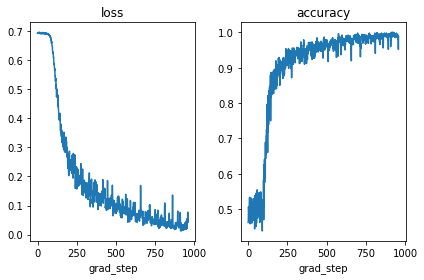

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(loss_trace)
ax2.plot(accuracy_trace)
ax1.set_title('loss')
ax2.set_title('accuracy')
ax1.set_xlabel('grad_step')
ax2.set_xlabel('grad_step')
plt.tight_layout()
plt.show()

In [10]:
print('Test Accuracy :', accuracy_run)

Test Accuracy : 0.84896


In [11]:
from sklearn.metrics import confusion_matrix 
cm = confusion_matrix(y_true=y_test, y_pred=y_test_pred)
print(cm)

[[11034  1466]
 [ 2310 10190]]
